In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.aw_hermite.setup_aw_hermite_two_stream import SimulationSetupTwoStreamHermite
from operators.poisson_solver import gmres_solver
from operators.aw_hermite.aw_hermite_operators import aw_psi_hermite, charge_density_two_stream_aw_hermite, total_mass_aw_hermite, total_momentum_aw_hermite, total_energy_k_aw_hermite

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

# Hermite bump-on-tail instability

In [4]:
setup = SimulationSetupTwoStreamHermite(Nx=101,
                                        Nv_e1=int(16),
                                        Nv_e2=int(2**6 - 16),
                                        epsilon=1e-4,
                                        alpha_e1=np.sqrt(2),
                                        alpha_e2=np.sqrt(2),
                                        alpha_i=np.sqrt(2 / 1836),
                                        u_e1=0,
                                        u_e2=10,
                                        u_i=0,
                                        L=20 * np.pi,
                                        dt=1e-2,
                                        T0=0,
                                        T=120,
                                        k0=0.1,
                                        nu_e1=1,
                                        nu_e2=10,
                                        n0_e1=0.99,
                                        n0_e2=0.01,
                                        alpha_tol=np.inf,
                                        u_tol=np.inf)

In [5]:
# ions (unperturbed + static)
C0_ions = np.ones(setup.Nx) / setup.alpha_i

In [6]:
# velocity grid for plotting purposes
v = np.linspace(-5, 15, int(15000), endpoint=True)
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx + 1, endpoint=True)

## simulation dataset

In [7]:
skip = 1

# load the simulation results
sol_midpoint_u = np.load("../../data/aw_hermite/bump_on_tail/sol_u_Nve1_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[:, ::skip]
sol_midpoint_t = np.load("../../data/aw_hermite/bump_on_tail/sol_t_Nve1_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[::skip]

setup.dt = setup.dt * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(6464, 12001)
(12001,)


In [8]:
alpha_e1 = np.repeat(setup.alpha_e1[-1], len(sol_midpoint_t))
u_e1 = np.repeat(setup.u_e1[-1], len(sol_midpoint_t))
alpha_e2 = np.repeat(setup.alpha_e2[-1], len(sol_midpoint_t))
u_e2 = np.repeat(setup.u_e2[-1], len(sol_midpoint_t))

In [9]:
runtime =  np.load("../../data/aw_hermite/bump_on_tail/sol_runtime_Nve1_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0)
            + "_" + str(setup.T) + ".npy")
runtime

array([3736.385762 , 1017.6393671])

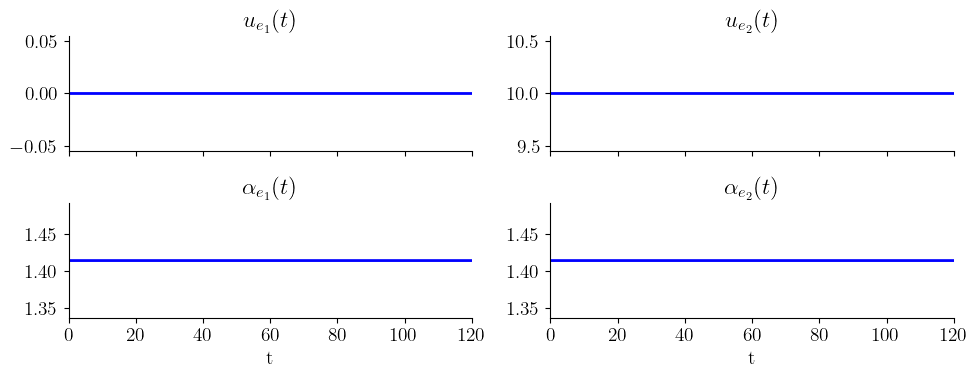

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(10, 4))
ax[0, 0].plot(sol_midpoint_t, u_e1, color="blue", linewidth=2)
ax[0, 0].set_title("$u_{e_{1}}(t)$")
ax[0, 1].plot(sol_midpoint_t, u_e2, color="blue", linewidth=2)
ax[0, 1].set_title("$u_{e_{2}}(t)$")

ax[1, 0].plot(sol_midpoint_t, alpha_e1, color="blue", linewidth=2)
ax[1, 0].set_title(r"$\alpha_{e_{1}}(t)$")
ax[1, 1].plot(sol_midpoint_t, alpha_e2, color="blue", linewidth=2)
ax[1, 1].set_title(r"$\alpha_{e_{2}}(t)$")

ax[1, 1].set_xlabel("t")
ax[1, 0].set_xlabel("t")
ax[1, 0].set_xlim(np.min(sol_midpoint_t), np.max(sol_midpoint_t))


ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].spines['top'].set_visible(False)

plt.tight_layout()
# plt.savefig("../figs/FOM/two_stream/adaptive_params_two_stream.png", dpi=500)

In [11]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [12]:
# initialize the states for implicit midpoint (symplectic)
state_e1_midpoint = np.zeros((setup.Nv_e1, setup.Nx + 1, len(sol_midpoint_t)))
state_e2_midpoint = np.zeros((setup.Nv_e2, setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv_e1,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t), 1):
    # print("time = ", sol_midpoint_t[ii])
    # unwind the flattening to solve the Vlasov-Poisson system
    # electrons species 1
    state_e1_midpoint[:, :-1, ii]  = np.reshape(sol_midpoint_u[:setup.Nv_e1*setup.Nx, ii], (setup.Nv_e1, setup.Nx)) 
    state_e1_midpoint[:, -1, ii] = state_e1_midpoint[:, 0, ii]
    # electrons species 2
    state_e2_midpoint[:, :-1, ii]  = np.reshape(sol_midpoint_u[setup.Nv_e1*setup.Nx:, ii], (setup.Nv_e2, setup.Nx))  
    state_e2_midpoint[:, -1, ii] = state_e2_midpoint[:, 0, ii]

    # immobile ions
    state_i_midpoint[0, :-1, ii] = C0_ions
    state_i_midpoint[0, -1, ii] = state_i_midpoint[0, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density_two_stream_aw_hermite(alpha_e1=alpha_e1[ii], 
                                            alpha_e2=alpha_e2[ii], 
                                            alpha_i=setup.alpha_i[-1],
                                        q_e1=setup.q_e1, q_e2=setup.q_e2, q_i=setup.q_i,
                                        C0_e1=state_e1_midpoint[0, :setup.Nx, ii],
                                        C0_e2=state_e2_midpoint[0, :setup.Nx, ii],
                                        C0_i=C0_ions)
    print(np.sum(rho))

    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D_inv=setup.D_inv, D=setup.D)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

2.220446049250313e-15
1.5543122344752192e-15
2.4424906541753444e-15
1.9984014443252818e-15
2.886579864025407e-15
2.1094237467877974e-15
2.4424906541753444e-15
1.887379141862766e-15
1.7763568394002505e-15
4.440892098500626e-16
9.992007221626409e-16
2.220446049250313e-16
9.992007221626409e-16
6.661338147750939e-16
-1.1102230246251565e-16
4.440892098500626e-16
2.220446049250313e-16
-6.661338147750939e-16
-2.220446049250313e-16
-1.7763568394002505e-15
1.5543122344752192e-15
-6.661338147750939e-16
2.220446049250313e-16
1.7763568394002505e-15
1.6653345369377348e-15
1.1102230246251565e-15
2.55351295663786e-15
2.886579864025407e-15
2.220446049250313e-15
1.7763568394002505e-15
1.1102230246251565e-15
1.2212453270876722e-15
2.220446049250313e-16
2.886579864025407e-15
2.3314683517128287e-15
7.771561172376096e-16
7.771561172376096e-16
1.2212453270876722e-15
9.992007221626409e-16
1.2212453270876722e-15
1.2212453270876722e-15
1.5543122344752192e-15
2.3314683517128287e-15
2.1094237467877974e-15
2.3314

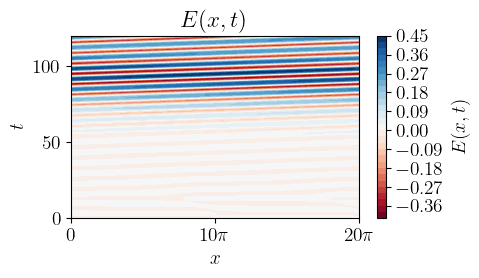

In [13]:
# plot the electric field
fig, ax = plt.subplots(figsize=(5, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 10*np.pi, 20*np.pi])
_ = ax.set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

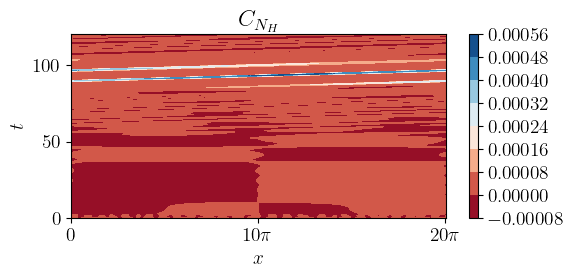

In [23]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, state_e1_midpoint[-1, :, :].T, cmap="RdBu")
cbar = fig.colorbar(pos)
ax.set_title("$C_{N_{H}}$")
ax.set_ylim(0, 120)
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 10*np.pi, 20*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

In [24]:
np.save("../../data/aw_hermite/bump_on_tail/E_field_" + str(setup.Nv_e1) + "_Nve2_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy", E_midpoint)

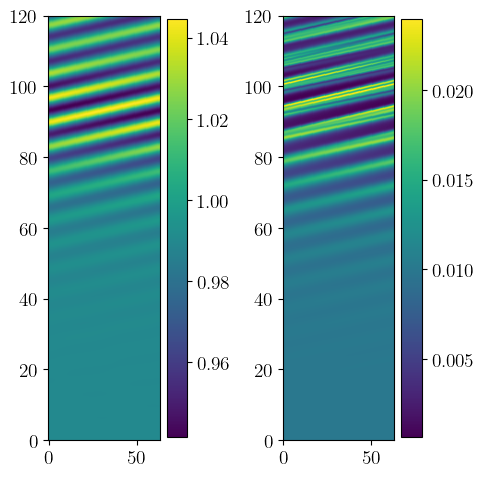

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(5, 5))
pos = ax[0].pcolormesh(x, sol_midpoint_t, alpha_e1[-1] * state_e1_midpoint[0, :, :].T) 
cbar = fig.colorbar(pos)
pos = ax[1].pcolormesh(x, sol_midpoint_t, alpha_e2[-1] * state_e2_midpoint[0, :, :].T) 
cbar = fig.colorbar(pos)
plt.tight_layout()
np.save("hermite_bulk_density.npy", alpha_e1[-1] * state_e1_midpoint[0, :, :])
np.save("hermite_beam_density.npy", alpha_e2[-1] * state_e2_midpoint[0, :, :])

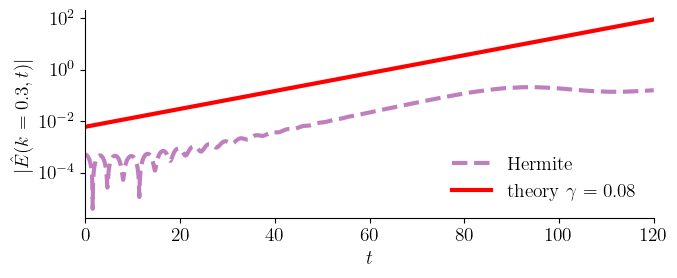

In [26]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(scipy.fft.fft(E_midpoint, axis=0, norm="forward"))[1, :], "--", c="purple", alpha=0.5, linewidth=3, label="Hermite") 
ax.plot(sol_midpoint_t, 0.006*np.exp(0.08*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = 0.08$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(k=0.3, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='lower right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../../figures/hermite/bump_on_tail/bump_on_tail_growth_rate_hermite.png", dpi=600)

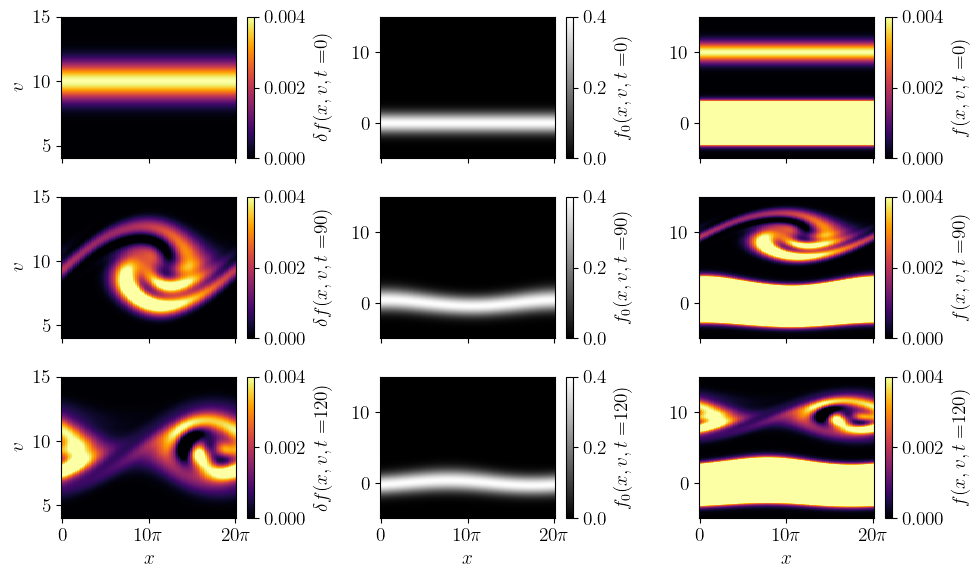

In [27]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 6), sharex=True)

levels = np.linspace(-0.05, 0.4, 50)

for tt, ii in enumerate([0, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution1 = np.zeros((len(x), len(v)))
    distribution2 = np.zeros((len(x), len(v)))
    for jj in range(setup.Nv_e1):
        distribution1 += np.outer(state_e1_midpoint[jj, :, ii], aw_psi_hermite(v=v, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
    for jj in range(setup.Nv_e2):
        distribution2 += np.outer(state_e2_midpoint[jj, :, ii], aw_psi_hermite(v=v, u_s=u_e2[ii], alpha_s=alpha_e2[ii], n=jj))
    pos2 = ax[tt, 0].pcolormesh(x, v, distribution2.T, cmap="inferno", vmin=0, vmax=0.004)
    pos1 = ax[tt, 1].pcolormesh(x, v, distribution1.T, cmap="gray", vmin=0, vmax=0.4)
    pos3 = ax[tt, 2].pcolormesh(x, v, distribution1.T + distribution2.T, cmap="inferno", vmin=0, vmax=0.004)
    #ax[tt, 0].set_yticks([-3, 0, 3, 6])
    ax[tt, 0].set_ylim(4, 15)
    ax[tt, 0].set_ylabel("$v$")
    cbar = fig.colorbar(pos1)
    cbar.ax.set_ylabel('$f_{0}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    #cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])

    cbar = fig.colorbar(pos2)
    cbar.ax.set_ylabel('$\delta f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    #cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])

    cbar = fig.colorbar(pos3)
    cbar.ax.set_ylabel('$f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    #cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
    
    
ax[tt, 0].set_xlabel("$x$")
ax[tt, 0].set_xticks([0, 10*np.pi, 20*np.pi])
ax[tt, 0].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
ax[tt, 2].set_xlabel("$x$")

ax[tt, 1].set_xlabel("$x$")
ax[tt, 1].set_xticks([0, 10*np.pi, 20*np.pi])
ax[tt, 1].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])

plt.tight_layout()
plt.savefig("../../figures/hermite/bump_on_tail/bump_on_tail_evolution_hermite_adapt.png", dpi=600)

In [28]:
np.save("../../data/aw_hermite/bump_on_tail/distribution_t_120_" + str(setup.Nv_e1) + "_Nve2_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy", distribution1 + distribution2)

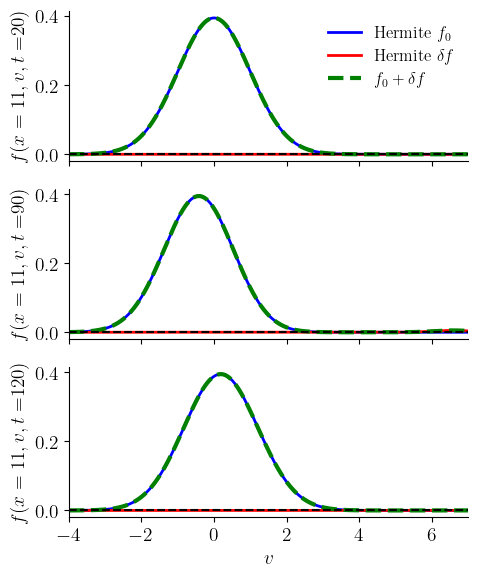

In [29]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 6), sharex=True)
for tt, ii in enumerate([2000, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution_H1 = np.zeros((len(x), len(v)))
    distribution_H2 = np.zeros((len(x), len(v)))
    for jj in range(setup.Nv_e1):
        distribution_H1 += np.outer(state_e1_midpoint[jj, :, ii], aw_psi_hermite(v=v, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
    for jj in range(setup.Nv_e2):
        distribution_H2 += np.outer(state_e2_midpoint[jj, :, ii], aw_psi_hermite(v=v, u_s=u_e2[ii], alpha_s=alpha_e2[ii], n=jj))
        
    _ = ax[tt].plot(v, distribution_H1[55, :], color="blue", label="Hermite $f_{0}$", linewidth=2)
    _ = ax[tt].plot(v, distribution_H2[55, :], color="red", label="Hermite $\delta f$", linewidth=2)
    _ = ax[tt].plot(v, distribution_H1[55, :] + distribution_H2[55, :], color="green", ls="--", label=r"$f_{0} + \delta f$", linewidth=3)
    ax[tt].spines['right'].set_visible(False)
    ax[tt].spines['top'].set_visible(False)
    ax[tt].set_xlim(-4, 7)
    ax[tt].set_ylabel("$f(x=11, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")
    ax[tt].axhline(0, color="black", ls="--")
    
legend = ax[0].legend(ncols=1, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
ax[-1].set_xlabel("$v$")
plt.tight_layout()
plt.savefig("../../figures/hermite/bump_on_tail/bump_on_tail_slice_hermite_adaptive_u_alpha.png", dpi=300)

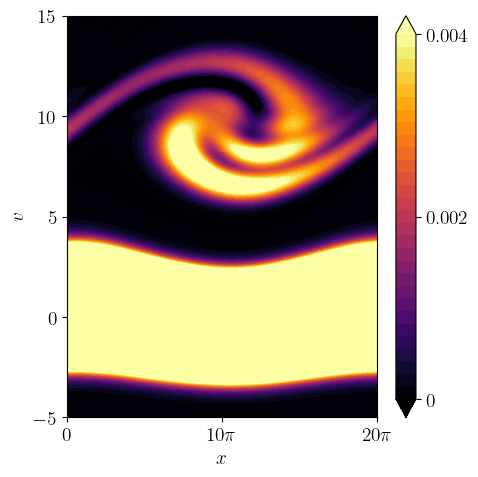

In [30]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)

ii = np.argmin(np.abs(sol_midpoint_t - 90))
distribution1 = np.zeros((len(x), len(v)))
distribution2 = np.zeros((len(x), len(v)))
for jj in range(setup.Nv_e1):
    distribution1 += np.outer(state_e1_midpoint[jj, :, ii], aw_psi_hermite(v=v, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
for jj in range(setup.Nv_e2):
    distribution2 += np.outer(state_e2_midpoint[jj, :, ii], aw_psi_hermite(v=v, u_s=u_e2[ii], alpha_s=alpha_e2[ii], n=jj))

pos = ax.contourf(x, v, distribution1.T+ distribution2.T, cmap="inferno", vmin=0, vmax=0.004, levels=np.linspace(0, 0.004, 30), extend="both")

ax.set_ylim(-5, 15)
ax.set_ylabel("$v$")
ax.set_xlabel("$x$")
cbar = fig.colorbar(pos)
cbar.set_ticks([0, 0.002, 0.004])
cbar.set_ticklabels(["0", "0.002", "0.004"])
ax.set_yticks([-5, 0, 5, 10, 15])
ax.set_xticks([0, 10*np.pi, 20*np.pi])
ax.set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
plt.tight_layout()
plt.savefig("../../figures/hermite/bump_on_tail/bump_on_tail_phase_space_hermite_t_90_Nv_" + str(setup.Nv_e1 + setup.Nv_e2) + ".png", dpi=300)

### mass conservation

In [20]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass_aw_hermite(state=state_e1_midpoint[:, :-1, ii], alpha_s=alpha_e1[ii], dx=setup.dx)\
                        +total_mass_aw_hermite(state=state_e2_midpoint[:, :-1, ii], alpha_s=alpha_e2[ii], dx=setup.dx)\
                        +total_mass_aw_hermite(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i[-1], dx=setup.dx)

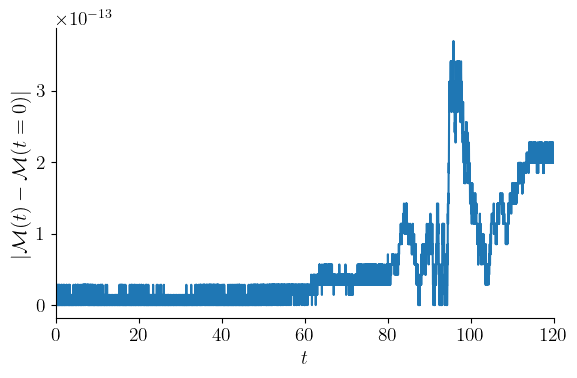

In [21]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{M}(t) - \mathcal{M}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
plt.tight_layout()

### momentum conservation

In [22]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_aw_hermite(state=state_e1_midpoint[:, :-1, ii], 
                                                   alpha_s=alpha_e1[ii], dx=setup.dx, m_s=setup.m_e1, u_s=u_e1[ii])\
                            +total_momentum_aw_hermite(state=state_e2_midpoint[:, :-1, ii],
                                                    alpha_s=alpha_e2[ii], dx=setup.dx, m_s=setup.m_e2, u_s=u_e2[ii])\
                            +total_momentum_aw_hermite(state=state_i_midpoint[:, :-1, ii],
                                                    alpha_s=setup.alpha_i[-1], dx=setup.dx, m_s=setup.m_i, u_s=setup.u_i[-1])

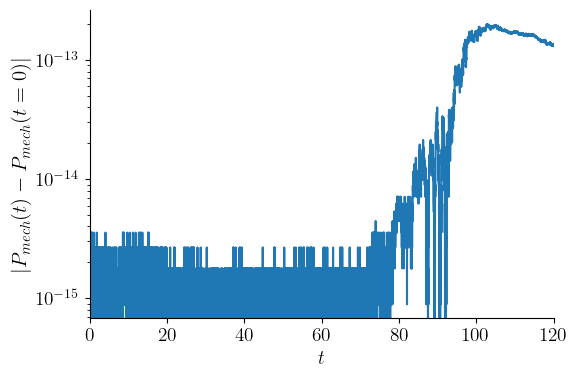

In [23]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
plt.tight_layout()

### energy conservation

In [24]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_aw_hermite(state=state_e1_midpoint[:, :-1, ii], 
                                                   alpha_s=alpha_e1[ii], dx=setup.dx, m_s=setup.m_e1, u_s=u_e1[ii])\
                            +total_energy_k_aw_hermite(state=state_e2_midpoint[:, :-1, ii],
                                                    alpha_s=alpha_e2[ii], dx=setup.dx, m_s=setup.m_e2, u_s=u_e2[ii])\
                            +total_energy_k_aw_hermite(state=state_i_midpoint[:, :-1, ii], 
                                                    alpha_s=setup.alpha_i[-1], dx=setup.dx, m_s=setup.m_i, u_s=setup.u_i[-1])
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

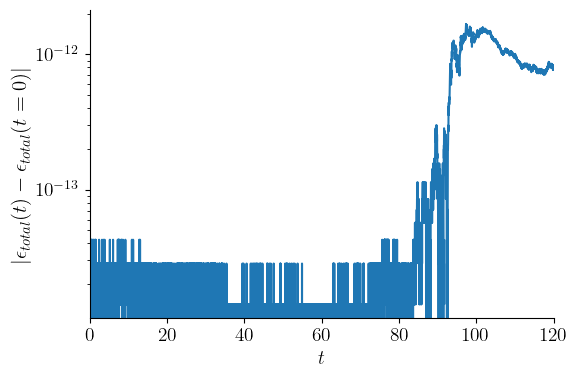

In [25]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

Text(0, 0.5, '$\\Delta E$')

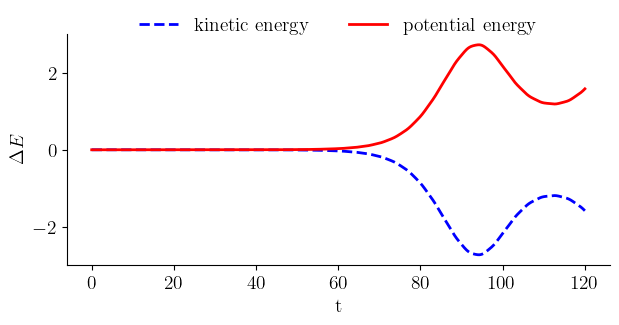

In [26]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
ax.set_ylabel(r"$\Delta E$")

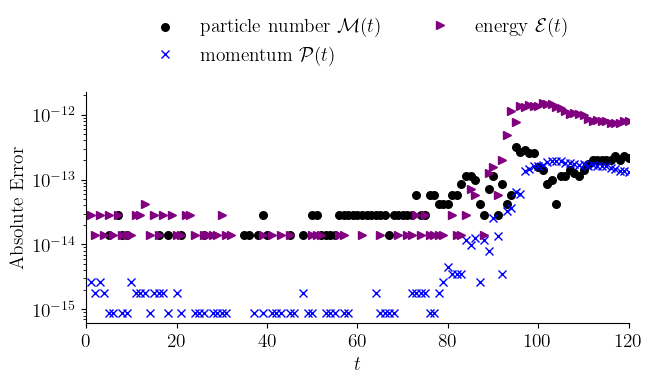

In [27]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
skip = 100

ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"particle number $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.4))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)

#plt.savefig("../figs/FOM/bump_on_tail/conservation_" + str(setup.Nv) + "_bump_on_tail_FOM.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)